# Gradient descent -- SUGRA potential with 4 parameters (x4,x11,x13,x9)

In this file, we

1) Read potentential from an external file

2) Choose the values for the parameters: 
    - Optimizer: e.g. Adam
    - n_points: Number of randomly initialised points
    - n_steps: Maximum number of steps in gradient descent algorithm
    - spread: size of the hypercube with initial data
    - alpha: initial learning rate
    - n_steps_opt: frequency with which the optimizer is rebooted
    - step_stop_opt: step from which the rebooting is cancelled

3) Perform gradient descent

4) Create /Output/ directory if unavailable and store:
    - Cloud of points and loss function into a .npy files
    - Ancillary file stating the choices above and showing the evolution of the learning process

5) Define visualisation functions


=========================

Changes since Oct 31st:

1) Directory of input file with potential changed
2) Number of variables 'dim' not defined in the notebook, but read from the input file

Changes since Nov 6th:

3) Gradient descent updated with optimiser rebooted every few steps

## Gradient Descent

In [10]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import tensorflow as tf

In [30]:
##############################
# Parameters
##############################

potential = "pot_4_param_4_11_13_9"                          # .py file with potential function V(x) and the number of variables 'dim'

time = np.datetime_as_string(np.datetime64('now'))
time = time.replace('-','_').replace('T','_at_').replace(':','_')

n_points = 10000                                       # Number of randomly initialised points
n_steps = 100000                                          # Maximum number of steps in gradient descent algorithm
spread = 2.2                                            # Initial values for the cloud of points in the hypercube [-spread/2, spread/2]^dim


alpha=10**(-3)              # Initial learning rate
n_steps_opt = 200           # Number of steps before rebooting optimizer
step_stop_opt = 1        


optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)

optimizer_info = optimizer.get_config()

In [31]:
print(time)

2024_12_19_at_13_53_29


In [32]:
# Saving directory
out_dir = os.getcwd()+'/Output/'

try:
    os.mkdir(out_dir)
    print(f"Directory '{out_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{out_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{out_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")


# Output File names
attempt = f"_{potential}_{n_points}_{time}"

info_file = out_dir + 'Comments' + attempt + '.txt'
data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'


f_info = open(info_file, 'w')


f_info.write(f'File created on {time}')
f_info.write(f'\n\nPotential : {potential}')
f_info.write(f'\nNumber of points: {n_points}')
f_info.write(f'\nNumber of steps: {n_steps}\n')
f_info.write(f'\nn_steps_opt: {n_steps_opt}\n')
f_info.write(f'\nstep_stop_opt: {step_stop_opt}\n')
f_info.write('\nOptimizer:\n')


for key, value in optimizer_info.items(): 
    f_info.write('  - %s : %s\n' % (key, value))

f_info.write('\nEvolution:')
f_info.flush()

Directory '/home/camille/Documents/Science/MLFlatDirections/Output/' already exists.


In [33]:
# Loading the potential
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim

print(dim)
help(V)

4
Help on function V in module pot_4_param_4_11_13_9:

V(x)
    0.125 * (tf.exp(2 * x13 -4 * (3 ** -0.5) * x9)) * (4 * (tf.exp(4 * (3 ** -0.5) * x9)) + 16 * (tf.exp(2 * x13 + 4 * (3 ** -0.5) * x9)) + (tf.exp(2 * (np.sqrt(3)) * x9)) * (x11 ** 4) -4 * (tf.exp(5 * (3 ** -0.5) * x9)) * (4 + x11 ** 2) + 8 * (tf.exp(2 * (3 ** -0.5) * x9)) * (-1 + 4 * (x4 ** 2)) + 4 * (tf.exp((np.sqrt(3)) * x9)) * (-4 + x11 ** 2) * (1 + 4 * (x4 ** 2)) + 4 * ((1 + 4 * (x4 ** 2)) ** 2))



In [34]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [35]:
# Randomly initialize the points
x = tf.Variable(spread*np.random.rand(n_points, dim)-(spread/2), dtype=tf.float32)


loss_history = []


# Learning loop 
for step in range(n_steps):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
        loss_history.append(loss)
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x])
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x]))
    
    # Update the information in info file
    if step % 500 == 0:
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        f_info.flush()
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        f_info.write("\n\nConverged enough") 
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

f_info.close()

# Saving loss and final cloud of points
np.save(data_file,x)
np.save(loss_file,loss_history)

In [15]:
# # Randomly initialize the points
# x = tf.Variable(np.random.rand(n_points, 3)+1, dtype=tf.float32)


# loss_history = []

# update_opt = False


# # Learning loop 
# for step in range(n_steps):  
#     with tf.GradientTape() as tape:
#         loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
#         loss_history.append(loss)
    
#     # Compute ||∇V||^2 with respect to x
#     gradients = tape.gradient(loss, [x])
        
#     # Apply gradient descent for all points
#     optimizer.apply_gradients(zip(gradients, [x]))
    
#     # Updates of optimizer
#     if update_opt and step % n_steps_opt ==0 :
#         print("Reinitializing the optimizer")
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)

#     if step == step_stop_opt:
#         update_opt = False
    
#     if (step - step_stop_opt)%(3*n_steps_opt) == 0:
#         alpha = alpha/10
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)


#     # Update the information in info file
#     if step % 500 == 0:
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         f_info.flush()
        
#     if np.log(loss.numpy())/np.log(10)<-8: 
#         f_info.write("\n\nConverged enough") 
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         break

# f_info.close()

# # Saving loss and final cloud of points
# np.save(data_file,x)
# np.save(loss_file,loss_history)

## Results

In [36]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import tensorflow as tf

### Functions

In [37]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [38]:
def triangular_plot(chains):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
    plt.show()

def triangular_plot_axes_lim(chains,mask):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[mask,j],data[mask,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
            ax.set_xlim([np.min(data[:,j]), np.max(data[:,j])])
            ax.set_ylim([np.min(data[:,i]), np.max(data[:,i])])
    plt.show()
    
# def triangular_plot(chains,figname):
#     data=chains
#     nsteps,ndim=chains.shape
#     fig = plt.figure(figsize=(20,20))
#     for i in range(ndim):
#         ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
#         ax.hist(data[:,i], 100, color="k", histtype="step")
#         ax.set_title(f"x{i+1} counts")

#     for i in range(ndim):
#         for j in range(i):
#             ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
#             counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
#             plt.colorbar(image)
#             ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
#             ax.set_xlabel(f'x{j+1}')
#             ax.set_ylabel(f'x{i+1}')
#     plt.savefig(figname)
#     plt.show()


def triangular_plot_slopes(chains):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(15,15))
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j}/x{i}")
    plt.show()

### Analysis

In [39]:
# Loading the potential
potential = "pot_4_param_4_11_13_9"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim

out_dir = os.getcwd()+'/Output/'
time = '2024_12_19_at_13_53_29'
n_points = 10000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'

In [40]:

x = tf.Variable(np.load(data_file), dtype=tf.float32)
loss_history = np.load(loss_file)

In [41]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(grad_norm_squared(V,x).numpy()>10**(-i))}")

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 310
Number of points with ||∇V||^2 > 1e-07 : 1057
Number of points with ||∇V||^2 > 1e-08 : 1955
Number of points with ||∇V||^2 > 1e-09 : 3153
Number of points with ||∇V||^2 > 1e-10 : 7016
Number of points with ||∇V||^2 > 1e-11 : 9620
Number of points with ||∇V||^2 > 1e-12 : 9885
Number of points with ||∇V||^2 > 1e-13 : 9963
Number of points with ||∇V||^2 > 1e-14 : 9966


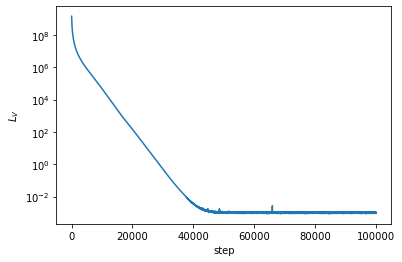

In [42]:
plt.figure(1)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('$L_{V}$')
plt.show()

<Figure size 432x288 with 0 Axes>

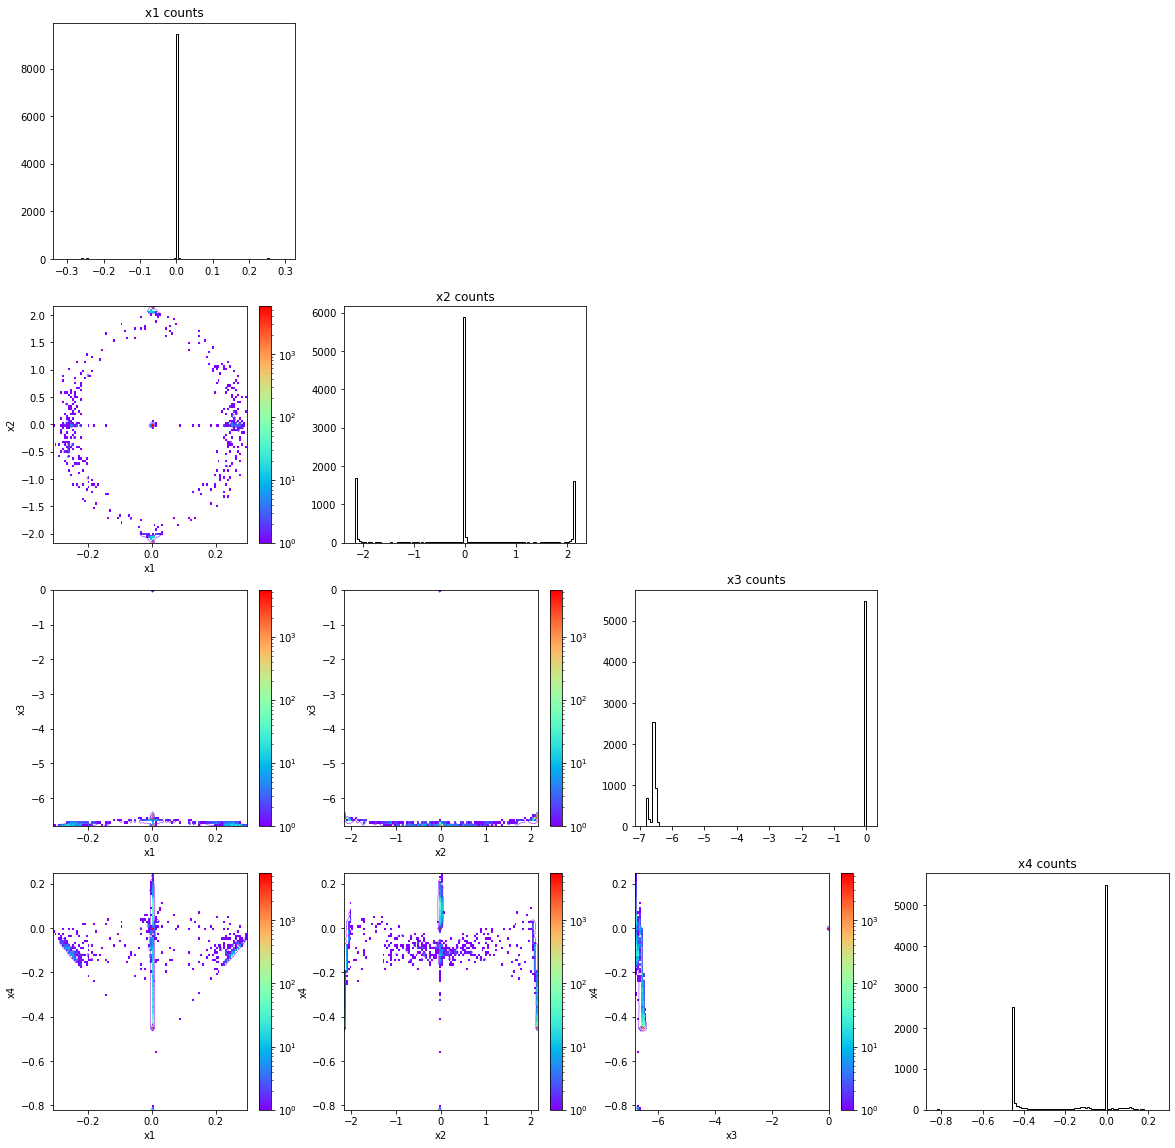

In [43]:
plt.figure(1)
triangular_plot(x.numpy())

Sum of the points are runaway (V\neq-2), we exclude them.

In [68]:
mask=(np.abs(V(x)+2)<1e-3)[:,0]

np.sum(mask)

5479

<Figure size 432x288 with 0 Axes>

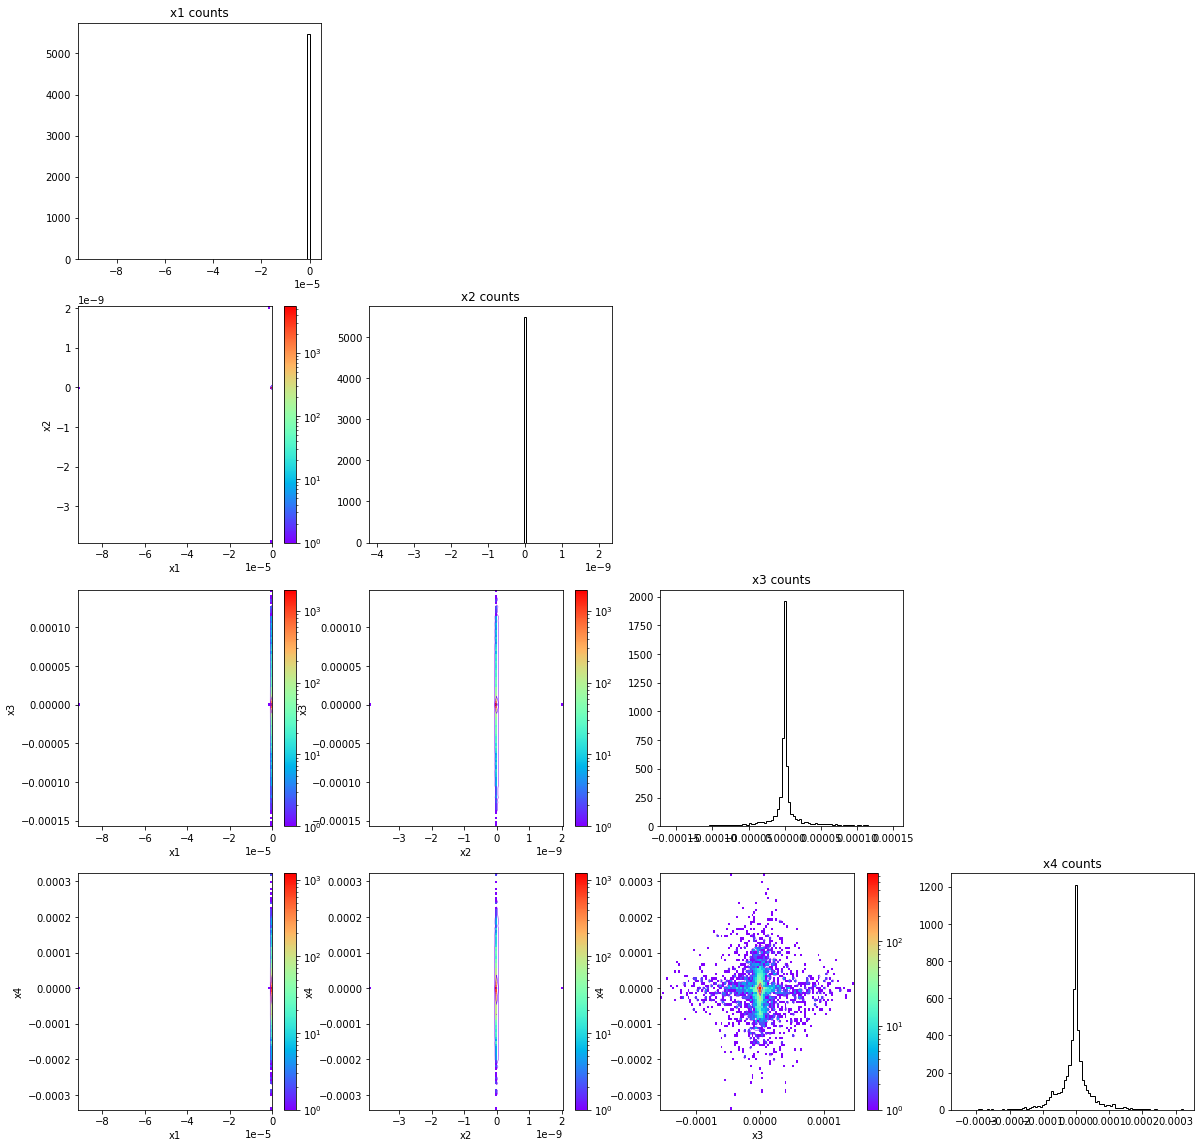

In [70]:
plt.figure(1)
triangular_plot(x[mask])

# So nothing, every points are set to zero.